
# Team Network demo

The goal of this notebook is to show network concepts that can aid college basketball analysis

- I'll start in the abstract, with simulated scores.
- Then I'll move to actual CBB data



### Introduction

There are around 350 teams in college basketball and there isn't enough time for them to all play each other. Teams instead are arranged in conferences that play each other regularly. Non-conference games offer a glimpse into relative strength between conferences, but they are limited. Therefore, we must infer some team strength from the strength of their opponents and their opponent's opponents. This naturally lends itself to network architecture.

If all teams played in a fully connected network, the network approach would be less useful. I'll demonstrate below.


##### Section 1. Comparing fully connected schedule vs. one with "conference" schedules

Let's first examine our ability to recover a "true rating" when all teams play each other once. For this first experiment, I'll use 18 teams to demonstrate.  

For simplicity, team with a rating "8" will beat a team with rating "0" by 8 points on average. However, there will be
randomness to the results. Home court advantage, overtime, etc. could be added but I decided against to keep things as simple as possible. 

The goal is to recover the "true rating".

In [1]:

import random

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns


from tqdm import tqdm
from faker import Faker
from itertools import combinations



## need to normalize true rating since it is relative, or else can have an average of -3 

fake = Faker()

# generate teams
teams = pd.DataFrame([(fake.name(), np.random.normal(0, 8)) for i in range(18)], columns=['name', 'true_rating'])

# need to normalize
teams['normalized_rating']  = (teams['true_rating'] - teams['true_rating'].mean())/teams['true_rating'].std()


teams.head()


,name,true_rating,normalized_rating
0,Nicholas Barnes,5.158604,0.676231
1,James Potts,-3.346976,-0.440923
2,Christopher Moody,1.286571,0.167664
3,Courtney Williams,-0.036641,-0.006131
4,Melissa Spencer,1.708800,0.223121


In [2]:

# Randomly generate game results with noise centered around true skill

def play_game(skill_1, skill_2, vol=6):
    return np.random.normal(skill_1, vol) - np.random.normal(skill_2, vol)


def play_season(schedule, skill_dict):
    
    game_results = []
    
    for game in schedule:
        
        team_1_true_skill = skill_dict[game[0]]
        team_2_true_skill = skill_dict[game[1]]
        
        game_result = play_game(team_1_true_skill, team_2_true_skill)
        game_results.append([game[0], game[1], game_result])
        game_results.append([game[1], game[0], -1*game_result])
    return pd.DataFrame(game_results, columns=['team_1','team_2','result'])

skill_dict = teams.copy().set_index('name').to_dict()['true_rating']
schedule = list(combinations(list(teams.name.values),2))

game_results = play_season(schedule, skill_dict)
game_results.head()


,team_1,team_2,result
0,Nicholas Barnes,James Potts,6.796080
1,James Potts,Nicholas Barnes,-6.796080
2,Nicholas Barnes,Christopher Moody,4.173751
3,Christopher Moody,Nicholas Barnes,-4.173751
4,Nicholas Barnes,Courtney Williams,17.189069



One way to recover the "true" rating from the random game results is to one hot encode each team, and then run a ridge regression with the result as the target. The corresponding coefficient will correlate will with the true rating.


In [3]:

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

def return_ratings_xy(rdata):
    
    y = rdata.result.values.reshape(-1,1)
    
    # don't need to shuffle for linear regression
    team_ohe = OneHotEncoder()
    team_X = team_ohe.fit_transform(rdata.team_1.values.reshape(-1,1)).toarray() # need toarray because it doesn't return a numpy object
    opp_ohe = OneHotEncoder()
    opp_X = opp_ohe.fit_transform(rdata.team_2.values.reshape(-1,1)).toarray()
    
    # save team ids for later
    team_order = np.array(team_ohe.categories_[0])
    X = np.concatenate((team_X, opp_X), axis=1)
    
    return X, y, team_order

def get_team_ratings(X, y, teams, ridge_alpha=0.1):
    
    model = Ridge(ridge_alpha)
    model.fit(X,y)
    team_ratings = model.coef_[0][:len(teams)]
    team_ratings = pd.DataFrame.from_dict({
        'name':teams,
        'model_rating':team_ratings
    })
    return team_ratings

X, y, team_order = return_ratings_xy(game_results)
model_ratings = get_team_ratings(X, y, team_order)
model_ratings['normalized_model_rating'] = (model_ratings['model_rating'].copy() - model_ratings['model_rating'].mean())/model_ratings['model_rating'].std()

model_ratings.head()



,name,model_rating,normalized_model_rating
0,Adriana Young,-8.297213,-0.988431
1,Anna Green,11.284314,1.344278
2,Arthur Potter,-17.038521,-2.029765
3,Ashley Gardner,15.729788,1.873859
4,Carol Gray,2.519613,0.300157


In [4]:

# merge in true ratings
results = model_ratings.copy().merge(teams.copy(), how='left')
results.head()


,name,model_rating,normalized_model_rating,true_rating,normalized_rating
0,Adriana Young,-8.297213,-0.988431,-4.106288,-0.540654
1,Anna Green,11.284314,1.344278,10.387801,1.363054
2,Arthur Potter,-17.038521,-2.029765,-16.407714,-2.156369
3,Ashley Gardner,15.729788,1.873859,13.409592,1.759947
4,Carol Gray,2.519613,0.300157,3.599610,0.471467


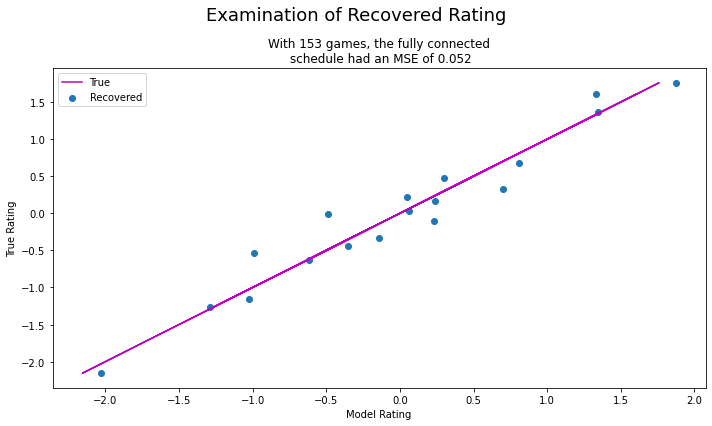

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(results.normalized_rating, results.normalized_rating, c='m', label='True')
plt.scatter(results.normalized_model_rating, results.normalized_rating, label='Recovered')

full_connected_error= np.round(np.mean((results['normalized_model_rating'].copy() - results['normalized_rating'].copy())**2),3)
plt.suptitle("Examination of Recovered Rating", fontsize=18)
plt.title(f"With {len(schedule)} games, the fully connected\n schedule had an MSE of {full_connected_error}")
plt.xlabel("Model Rating")
plt.ylabel("True Rating")
plt.legend()
plt.tight_layout()
plt.show()



This is great, but we really need to bootstrap to get a lot of samples for a fair comparison.




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 26.12it/s]


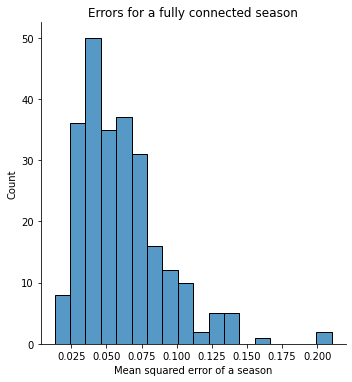

In [6]:

def sim_fc_season():
    
    fake = Faker()
    
    # generate teams
    teams = pd.DataFrame([(fake.name(), np.random.normal(0, 8)) for i in range(18)], columns=['name', 'true_rating'])
    # need to normalize
    teams['normalized_rating']  = (teams['true_rating'] - teams['true_rating'].mean())/teams['true_rating'].std()
    # create schedule
    skill_dict = teams.copy().set_index('name').to_dict()['true_rating']
    schedule = list(combinations(list(teams.name.values),2))
    # run season
    game_results = play_season(schedule, skill_dict)
    # run model
    X, y, team_order = return_ratings_xy(game_results)
    model_ratings = get_team_ratings(X, y, team_order)
    model_ratings['normalized_model_rating'] = (model_ratings['model_rating'].copy() - model_ratings['model_rating'].mean())/model_ratings['model_rating'].std()
    # get error
    results = model_ratings.copy().merge(teams.copy(), how='left')
    return np.mean((results['normalized_model_rating'].copy() - results['normalized_rating'].copy())**2)

fc_errors = []
for i in tqdm(range(250)):
    fc_error = sim_fc_season()
    fc_errors.append(fc_error)
    
sns.displot(fc_errors)
plt.title("Errors for a fully connected season")
plt.xlabel("Mean squared error of a season")
plt.show()


This time, I will do the same amount of games for each team. However, there will be 3 "conferences" of 6 teams each. To demonstrate potential problems with estimating relative conference skill, each team will play 15 conference games and 2 non-conference games.

In college basketball, the distribution of conference and non-conference games is more even. However, the last half of the schedule is all conference games, and so information about relative conference strength becomes stale. I will explore that in later cells.


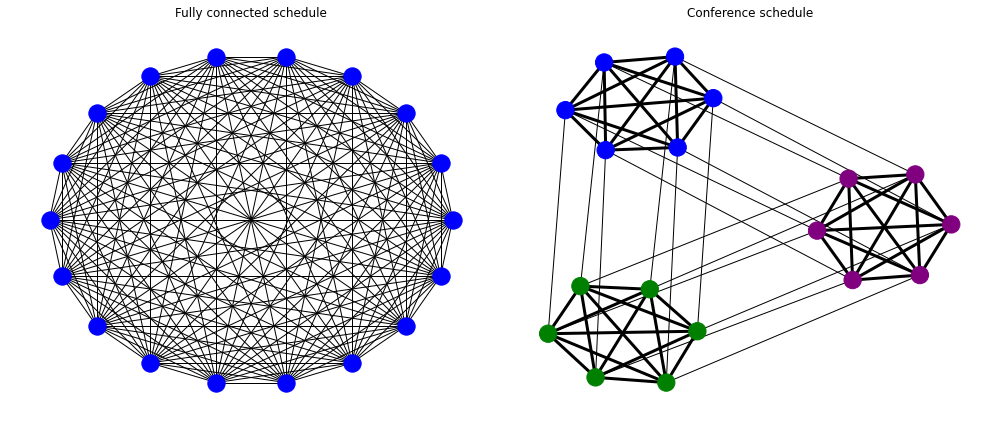

In [51]:

def get_conference_schedule(teams):
    
    """
    
    Generates conference and non-con schedule with each team playing each team in their conference 3 times
    2 non-con games, one from each other conference
    
    """
    
    team_names = list(teams.name)
    random.shuffle(team_names)
    conf_affiliation = {

    }
    conf_a_teams = []
    conf_b_teams = []
    conf_c_teams = []

    for conf_a_name in team_names[:6]:
        conf_affiliation[conf_a_name] = 'A'
        conf_a_teams.append(conf_a_name)
    for conf_b_name in team_names[6:12]:
        conf_affiliation[conf_b_name] = 'B'
        conf_b_teams.append(conf_b_name)
    for conf_c_name in team_names[12:]:
        conf_affiliation[conf_c_name] = 'C'
        conf_c_teams.append(conf_c_name)

    conf_a_schedule = list(combinations(conf_a_teams,2)) * 3
    conf_b_schedule = list(combinations(conf_b_teams,2)) * 3
    conf_c_schedule = list(combinations(conf_c_teams,2)) * 3

    full_schedule = conf_a_schedule + conf_b_schedule + conf_c_schedule

    for i in range(6):
        full_schedule.extend([(conf_a_teams[i], conf_b_teams[i]), (conf_a_teams[i], conf_c_teams[i]), (conf_c_teams[i], conf_b_teams[i])])

    assert(len(full_schedule)==153)
    teams['conf_name'] = teams['name'].map(conf_affiliation)
    
    return conf_affiliation, full_schedule

conf_affiliation, conf_schedule = get_conference_schedule(teams)
# change conf_schedule to weighted graph
conf_schedule = pd.DataFrame(conf_schedule, columns=['team_1','team_2']).drop_duplicates().reset_index(drop=True)
conf_schedule['team_1_conf'] = conf_schedule['team_1'].map(conf_affiliation)
conf_schedule['team_2_conf'] = conf_schedule['team_2'].map(conf_affiliation)
conf_schedule['weight'] = np.where(conf_schedule['team_1_conf'].copy()==conf_schedule['team_2_conf'].copy(), 3, 1)

conf_schedule = list(conf_schedule[['team_1','team_2','weight']].values)
conf_schedule = [tuple(row) for row in conf_schedule]

### illustrating ###

g1 = nx.MultiGraph()
g2 = nx.Graph()

g1.add_nodes_from(list(team_order))
g2.add_nodes_from(list(team_order))

g1.add_edges_from(schedule)
g2.add_weighted_edges_from(conf_schedule)

conf_colormap = {
    'A':'blue',
    'B':'green',
    'C':'purple'
}
colormap = []
for node in g2:
    colormap.append(conf_colormap[conf_affiliation[node]])
fig, axes = plt.subplots(1, 2, figsize=(14,6))

ax1 = axes[0]
ax2 = axes[1]
ax1.set_title('Fully connected schedule')
ax2.set_title('Conference schedule')
nx.draw_circular(g1, ax=ax1, node_color='blue')
pos = nx.spring_layout(g2)
labels = nx.get_edge_attributes(g2,'weight')

weights = [g2[u][v]['weight'] for u,v in g2.edges()]
nx.draw_networkx(g2, pos, ax=ax2, node_color=colormap,width=weights,with_labels=False)
ax2.axis("off")
plt.tight_layout()



In [52]:

def sim_conf_season():
    
    fake = Faker()
    
    # generate teams
    teams = pd.DataFrame([(fake.name(), np.random.normal(0, 8)) for i in range(18)], columns=['name', 'true_rating'])
    teams['normalized_rating']  = (teams['true_rating'] - teams['true_rating'].mean())/teams['true_rating'].std()
    # create schedule
    skill_dict = teams.copy().set_index('name').to_dict()['true_rating']
    conf_affiliation, conf_schedule = get_conference_schedule(teams)
    # run season
    game_results = play_season(conf_schedule, skill_dict)
    # run model
    X, y, team_order = return_ratings_xy(game_results)
    model_ratings = get_team_ratings(X, y, team_order)
    model_ratings['normalized_model_rating'] = (model_ratings['model_rating'].copy() - model_ratings['model_rating'].mean())/model_ratings['model_rating'].std()
    # get error
    results = model_ratings.copy().merge(teams.copy(), how='left')
    return np.mean((results['normalized_model_rating'].copy() - results['normalized_rating'].copy())**2)

conf_errors = []
for i in tqdm(range(250)):
    conf_error = sim_conf_season()
    conf_errors.append(conf_error)




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:10<00:00, 24.47it/s]


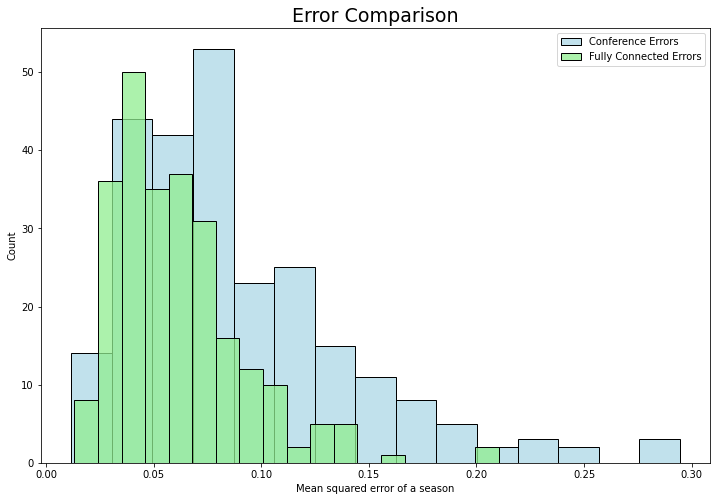

In [63]:


fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(conf_errors, ax=ax, color='lightblue', label='Conference Errors')
sns.histplot(fc_errors, ax=ax, color='lightgreen', label='Fully Connected Errors')
plt.title("Error Comparison", fontsize=19)
plt.xlabel("Mean squared error of a season")
plt.legend()
plt.show()



### Summary

Visually, it is obvious that a conference schedule makes it much more difficult to forecast team skill. This is because it is hard to know, from limited data, how the conferences sit relative to each other. Non-conference games essentially act as "information bottlenecks". Could it be beneficial to weigh these limited non-conference games heavier?


To do this, we'll use edge betweenness centrality. 


In [70]:


def return_ratings_xy_ebc(rdata):
    
    y = rdata.result.values.reshape(-1,1)
    
    # don't need to shuffle for linear regression
    team_ohe = OneHotEncoder()
    team_X = team_ohe.fit_transform(rdata.team_1.values.reshape(-1,1)).toarray() # need toarray because it doesn't return a numpy object
    opp_ohe = OneHotEncoder()
    opp_X = opp_ohe.fit_transform(rdata.team_2.values.reshape(-1,1)).toarray()
    
    # save team ids for later
    team_order = np.array(team_ohe.categories_[0])
    X = np.concatenate((team_X, opp_X), axis=1)
    
    return X, y, team_order

def get_team_ratings_ebc(X, y, teams, ridge_alpha=0.1):
    
    model = Ridge(ridge_alpha)
    model.fit(X,y)
    team_ratings = model.coef_[0][:len(teams)]
    team_ratings = pd.DataFrame.from_dict({
        'name':teams,
        'model_rating':team_ratings
    })
    return team_ratings


def sim_conf_season_ebc():
    
    fake = Faker()
    
    # generate teams
    teams = pd.DataFrame([(fake.name(), np.random.normal(0, 8)) for i in range(18)], columns=['name', 'true_rating'])
    teams['normalized_rating']  = (teams['true_rating'] - teams['true_rating'].mean())/teams['true_rating'].std()
    # create schedule
    skill_dict = teams.copy().set_index('name').to_dict()['true_rating']
    conf_affiliation, conf_schedule = get_conference_schedule(teams)
    ebc = nx.edge_betweenness_centrality(g2)
    # run season
    game_results = play_season(conf_schedule, skill_dict)
    # run model
    X, y, team_order = return_ratings_xy(game_results)
    model_ratings = get_team_ratings(X, y, team_order)
    model_ratings['normalized_model_rating'] = (model_ratings['model_rating'].copy() - model_ratings['model_rating'].mean())/model_ratings['model_rating'].std()
    # get error
    results = model_ratings.copy().merge(teams.copy(), how='left')
    return np.mean((results['normalized_model_rating'].copy() - results['normalized_rating'].copy())**2)

conf_errors = []
for i in tqdm(range(250)):
    conf_error = sim_conf_season()
    conf_errors.append(conf_error)
## edge betweenness centrality essentially measures how much of a bottleneck an edge is
ebc = nx.edge_betweenness_centrality(g2)
ebc



{('Adriana Young', 'Nicolas Elliott Jr.'): 0.0196078431372549,
 ('Adriana Young', 'Christopher Moody'): 0.0196078431372549,
 ('Adriana Young', 'Arthur Potter'): 0.0196078431372549,
 ('Adriana Young', 'Anna Green'): 0.0196078431372549,
 ('Adriana Young', 'Kelly Martin DDS'): 0.0196078431372549,
 ('Adriana Young', 'Melissa Spencer'): 0.0392156862745098,
 ('Adriana Young', 'Kelly Freeman'): 0.0392156862745098,
 ('Anna Green', 'Nicolas Elliott Jr.'): 0.0196078431372549,
 ('Anna Green', 'Christopher Moody'): 0.0196078431372549,
 ('Anna Green', 'Arthur Potter'): 0.0196078431372549,
 ('Anna Green', 'Kelly Martin DDS'): 0.0196078431372549,
 ('Anna Green', 'Kari Miller'): 0.0392156862745098,
 ('Anna Green', 'Nicholas Barnes'): 0.0392156862745098,
 ('Arthur Potter', 'Nicolas Elliott Jr.'): 0.0196078431372549,
 ('Arthur Potter', 'Christopher Moody'): 0.0196078431372549,
 ('Arthur Potter', 'Kelly Martin DDS'): 0.0196078431372549,
 ('Arthur Potter', 'James Moyer'): 0.0392156862745098,
 ('Arthur Pot

In [74]:
conf_affiliation, conf_schedule = get_conference_schedule(teams)
conf_schedule

[('Kelly Martin DDS', 'Anna Green'),
 ('Kelly Martin DDS', 'James Potts'),
 ('Kelly Martin DDS', 'James Moyer'),
 ('Kelly Martin DDS', 'Courtney Williams'),
 ('Kelly Martin DDS', 'Ashley Gardner'),
 ('Anna Green', 'James Potts'),
 ('Anna Green', 'James Moyer'),
 ('Anna Green', 'Courtney Williams'),
 ('Anna Green', 'Ashley Gardner'),
 ('James Potts', 'James Moyer'),
 ('James Potts', 'Courtney Williams'),
 ('James Potts', 'Ashley Gardner'),
 ('James Moyer', 'Courtney Williams'),
 ('James Moyer', 'Ashley Gardner'),
 ('Courtney Williams', 'Ashley Gardner'),
 ('Kelly Martin DDS', 'Anna Green'),
 ('Kelly Martin DDS', 'James Potts'),
 ('Kelly Martin DDS', 'James Moyer'),
 ('Kelly Martin DDS', 'Courtney Williams'),
 ('Kelly Martin DDS', 'Ashley Gardner'),
 ('Anna Green', 'James Potts'),
 ('Anna Green', 'James Moyer'),
 ('Anna Green', 'Courtney Williams'),
 ('Anna Green', 'Ashley Gardner'),
 ('James Potts', 'James Moyer'),
 ('James Potts', 'Courtney Williams'),
 ('James Potts', 'Ashley Gardner'